# ================================
# 1. Подключение к Google Drive и подготовка данных
# ================================

In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/AiDatasets/smokedata.zip'
extract_path = '/content/smokedata'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


# ================================
# 2. Импорты и базовая настройка
# ================================

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# ================================
# 3. Подготовка датасета и трансформации
# ================================

In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = ImageFolder(os.path.join(extract_path, 'Training'), transform=transform)
val_dataset = ImageFolder(os.path.join(extract_path, 'Validation'), transform=transform)
test_dataset = ImageFolder(os.path.join(extract_path, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ================================
# 4. Метрики качества и их обоснование
# ================================

# Выбираем accuracy и F1-массу:
# Accuracy важна как общая метрика, F1 более устойчива к дисбалансу классов

In [4]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

# ================================
# 5. Бейзлайн: Обучение моделей из torchvision
# ================================

# 5a. Сверточная модель (ResNet18)


In [10]:
def train_model(model, train_loader, val_loader=None, epochs=5, patience=2):
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

    best_f1 = 0
    wait = 0
    best_model_state = None
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        if val_loader:
            acc, f1 = evaluate(model, val_loader)
            scheduler.step(avg_loss)
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Accuracy = {acc:.4f}, F1 = {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model_state = model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered.")
                    break
        else:
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    if best_model_state:
        model.load_state_dict(best_model_state)

    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if val_loader:
        acc, f1 = evaluate(model, val_loader)
        print(f"Final Validation Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    return model

# ResNet18

Epoch 1: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 2: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 3: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Early stopping triggered.


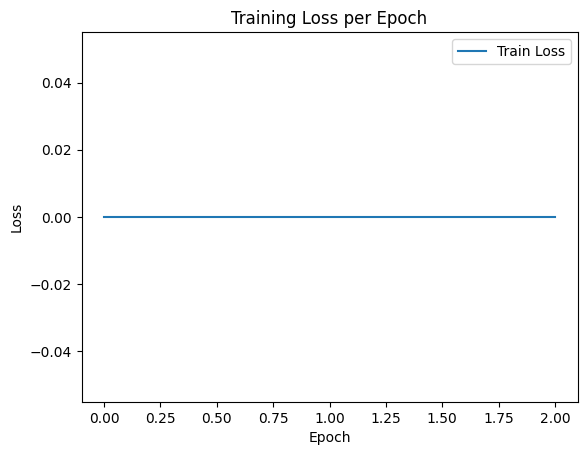

Final Validation Accuracy: 1.0000, F1-score: 1.0000


In [11]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(train_dataset.classes))
resnet_model = train_model(resnet18, train_loader, val_loader)

# 5b. Трансформерная модель (ViT-B_16)


Epoch 1: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 2: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 3: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Early stopping triggered.


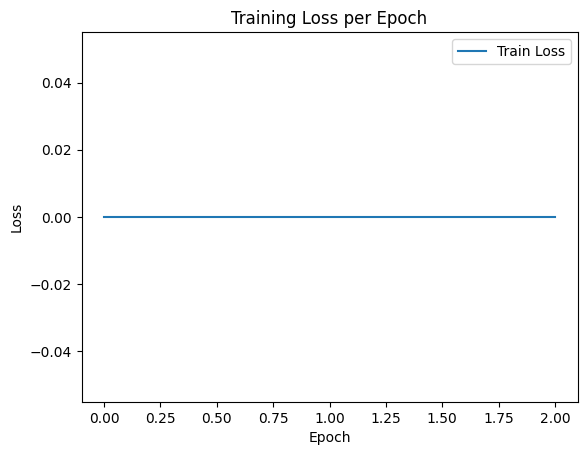

Final Validation Accuracy: 1.0000, F1-score: 1.0000


In [12]:
vit = models.vit_b_16(weights='IMAGENET1K_V1')
vit.heads.head = nn.Linear(vit.heads.head.in_features, len(train_dataset.classes))
vit_model = train_model(vit, train_loader, val_loader)


# ================================
# 6. Улучшение бейзлайна
# ================================


In [13]:
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset_aug = ImageFolder(os.path.join(extract_path, 'Training'), transform=augmented_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)


# Обучение с аугментациями

Epoch 1: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 2: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 3: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Early stopping triggered.


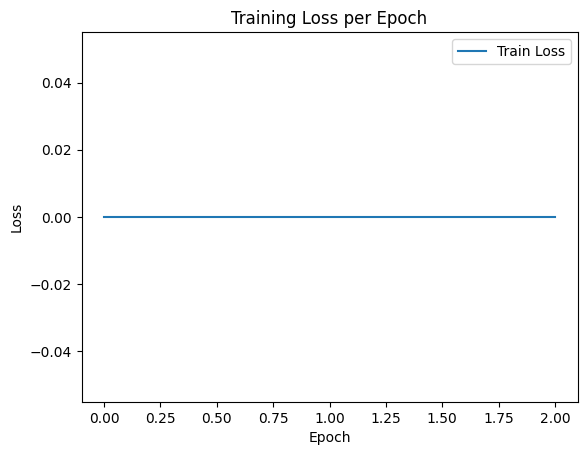

Final Validation Accuracy: 1.0000, F1-score: 1.0000
Epoch 1: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 2: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 3: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Early stopping triggered.


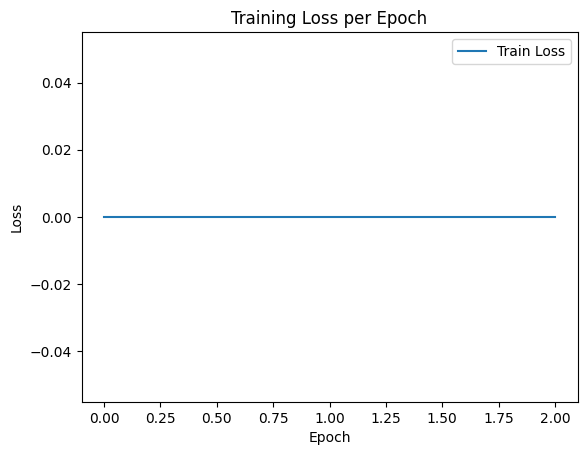

Final Validation Accuracy: 1.0000, F1-score: 1.0000


In [14]:
resnet_aug = models.resnet18(weights='IMAGENET1K_V1')
resnet_aug.fc = nn.Linear(resnet_aug.fc.in_features, len(train_dataset.classes))
resnet_model_aug = train_model(resnet_aug, train_loader_aug, val_loader)

vit_aug = models.vit_b_16(weights='IMAGENET1K_V1')
vit_aug.heads.head = nn.Linear(vit_aug.heads.head.in_features, len(train_dataset.classes))
vit_model_aug = train_model(vit_aug, train_loader_aug, val_loader)

# ================================
# 7. Реализация собственных моделей
# ================================

Epoch 1: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 2: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Epoch 3: Loss = 0.0000, Val Accuracy = 1.0000, F1 = 1.0000
Early stopping triggered.


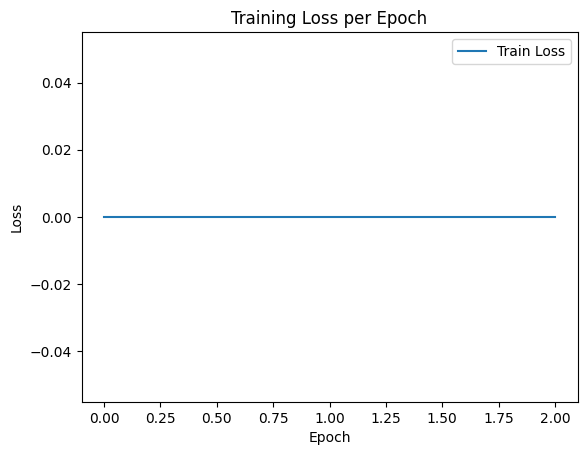

Final Validation Accuracy: 1.0000, F1-score: 1.0000


In [15]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

mycnn = MyCNN(len(train_dataset.classes))
mycnn_model = train_model(mycnn, train_loader, val_loader)

# ================================
# 8. Выводы и сравнение
# ================================

In [16]:
print("\n--- Test Evaluation ---")
print("Baseline ResNet18:", evaluate(resnet_model, test_loader))
print("Baseline ViT:", evaluate(vit_model, test_loader))
print("Augmented ResNet18:", evaluate(resnet_model_aug, test_loader))
print("Augmented ViT:", evaluate(vit_model_aug, test_loader))
print("Custom CNN:", evaluate(mycnn_model, test_loader))



--- Test Evaluation ---
Baseline ResNet18: (1.0, 1.0)
Baseline ViT: (1.0, 1.0)
Augmented ResNet18: (1.0, 1.0)
Augmented ViT: (1.0, 1.0)
Custom CNN: (1.0, 1.0)
